### Aim of anlysis
After viewing all forests in the world and characteristics of tropical dry forests. I want to perform analysis on the <b>Southern New Guinea freshwater swamp forest</b>

# **DATASETS DESCRIPTION**

**Administrative bounndaries from external data source**

* `world_data` - **Administrative boundaries of all countries in the world** (data source: https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/)
 * `continent` - **Administrative boundaries of all countries in Africa** (data source: clipped from world_data based on observations that have continent as Africa)
 * `subregion` - **Administrative boundaries of all countries in West Africa** (data source: clipped from continent based on observations that have subregion as Western Africa)

> The following dataset is gotten from the data library [here](https://datasets.mojaglobal.workers.dev/0:/)

1. **Bioclimatic & Ecological Zones**

  * `fav_forest` - **Southern New Guinea freshwater swamp forests** (data source: GlobalAgroEcologicalZones_GAEZ.geojson, I filtered observation on Southern New Guinea freshwater swamp forests from the data)
 * `agroeco_df` - **Global AgroEcological Zones** (data source: GlobalAgroEcologicalZones_GAEZ.geojson)
 * `gaez` - **AGro ecological zones of Southern New Guinea freshwater swamp forests** (data source: clipped data on agroeco_df and fav_forest)
 * `clipped1` - **.tiff files on `water scarcity, soil resource nutrients, dominant land cover, rainfed soil terrain suitability, rooting conditions, protected areas, protected areas restricted agricultures`**

2. Climate
 * `cliamte` - **IPCC Climate zone map** (data source: IPCC_ClimateZoneMap_Vector.geojson)
 * `clim` - **Climate zones of Southern New Guinea freshwater swamp forests** (data source: clipped data on climate and fav_forest)
 * `clim_shift` - **Climate shifts according to Koppen-Geiger from 1901 - 2000 and 2001 to 2100 based on different scenarios** ( data source: KoppenGeigerClimateShifts/)
 * `forest_clim_shift` - **Climate shifts of Southern New Guinea freshwater swamp forests** (data source: clipped data on clim_shift and fav_forest)

In [1]:
from shapely.geometry import mapping
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rioxarray as rxr
import earthpy as et
import rasterio
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')
import requests

In [2]:
class Read():
    def __init__(self, url, columns = None):
        self.url = url
        self.columns = columns
        
    def retrieve_data(self):
        self.req = requests.get(self.url)
        self.req = str(self.req.text)

    def wrangle(self, online = False, change_columns = False, new_columns = None, replace_values = False,
               column_to_replace= None, replacing_values = None):
        if online:
            self.url = self.req
        self.df = gpd.read_file(self.url)
        if change_columns:
            self.df = self.df[self.columns]
            self.df.columns = new_columns
        self.df = self.df.replace(['n/a', 'Unknown'], np.nan)
        self.df.columns = self.df.columns.str.lower()
        if replace_values:
            self.df[column_to_replace] = self.df[column_to_replace].replace(replacing_values)
        self.df['centroid'] = self.df.geometry.centroid
        self.df.crs = {'init' :'epsg:4326'}
        return self.df

In [3]:
def plot(data, column):
    data.plot(column = column, legend = True, cmap = 'winter',
          legend_kwds = {'ncol': 2, 'loc' : 'center', 'bbox_to_anchor': (1.5, 0.5)})
    plt.xlim(-20,20)

In [4]:
def plot_within(data, column, title, ncol):
    ax = data.plot(column = column,  figsize= (20, 8), legend = True, cmap = 'winter',
                        legend_kwds = {'ncol': ncol, 'loc' : 'center', 'bbox_to_anchor': (1.2, 0.5)})
    fav_forest.plot(ax = ax, color = 'brown')
    plt.title(title, fontdict = {'fontsize' : 18});

In [5]:
fav_forest = Read('data/Southern New Guinea freshwater swamp forest.geojson')
fav_forest = fav_forest.wrangle()

fav_forest.head(2)

eco_name  \
0  Southern New Guinea freshwater swamp forests   
1  Southern New Guinea freshwater swamp forests   

                                              biome  \
0  Tropical and subtropical moist broadleaf forests   
1  Tropical and subtropical moist broadleaf forests   

                                            geometry  \
0  MULTIPOLYGON (((-71.50326 19.64724, -71.51349 ...   
1  POLYGON ((-86.86259 21.00049, -86.86257 21.007...   

                     centroid  
0  POINT (-71.50366 19.67890)  
1  POINT (-86.81104 21.07838)

In [6]:
print(f"biomes of Southern New Guinea freshwater swamp forests are:{list(fav_forest['biome'].unique())}")

biomes of Southern New Guinea freshwater swamp forests are:['Tropical and subtropical moist broadleaf forests']


### Administrative

In [7]:
columns = ['CONTINENT','NAME_LONG', 'SUBREGION', 'geometry']
new_columns = ['continent', 'country', 'SUBREGION', 'geometry']
world_data = Read('zip://data/ne_110m_admin_0_countries.zip', columns)
world_data = world_data.wrangle(change_columns = True, new_columns = new_columns)
continent = world_data[world_data['continent'] == 'Africa']
subregion = continent[continent['subregion'] == 'Western Africa']

continent.head(2)

continent         country        subregion  \
1    Africa        Tanzania   Eastern Africa   
2    Africa  Western Sahara  Northern Africa   

                                            geometry  \
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...   

                     centroid  
1   POINT (34.75299 -6.25773)  
2  POINT (-12.13783 24.29117)

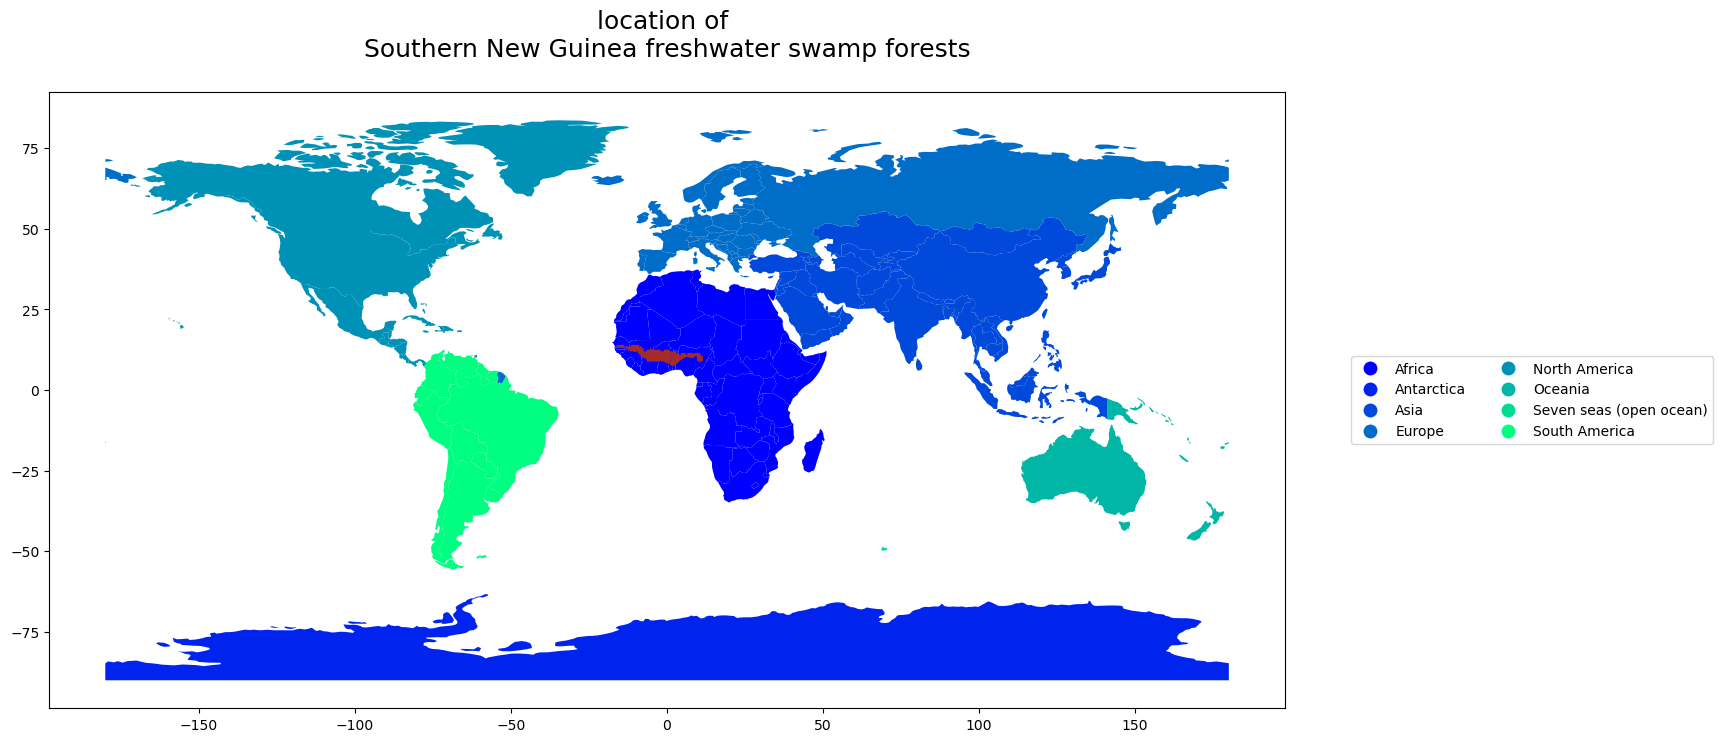

In [8]:
plot_within(world_data, 'continent', 'location of \nSouthern New Guinea freshwater swamp forests\n', 2)

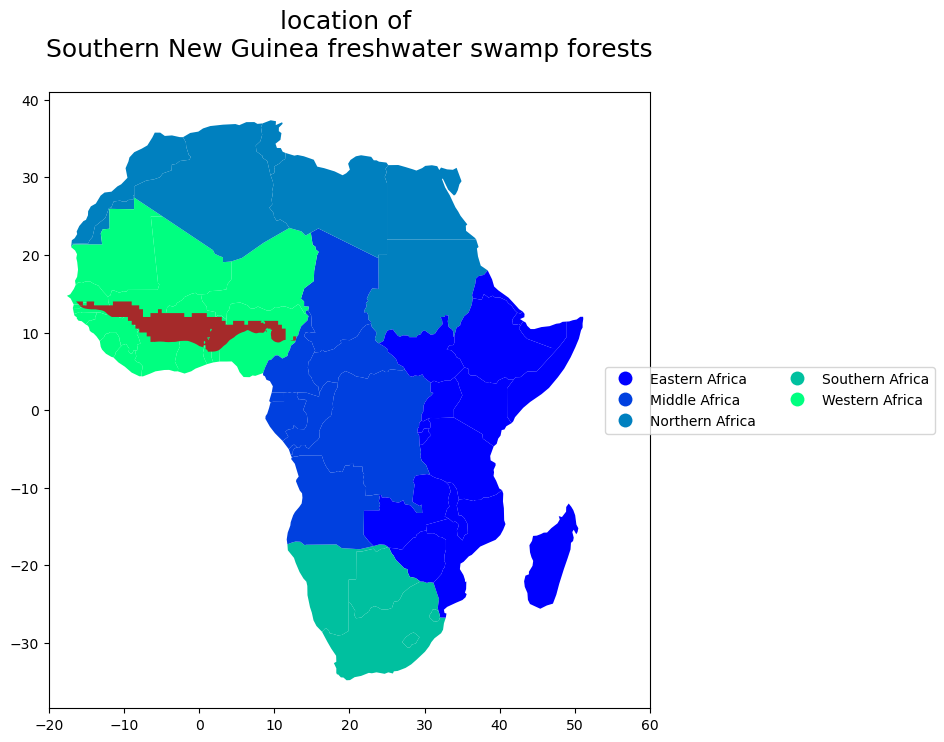

In [9]:
plot_within(continent, 'subregion', 'location of \nSouthern New Guinea freshwater swamp forests\n', 2)
plt.xlim(-20,60);

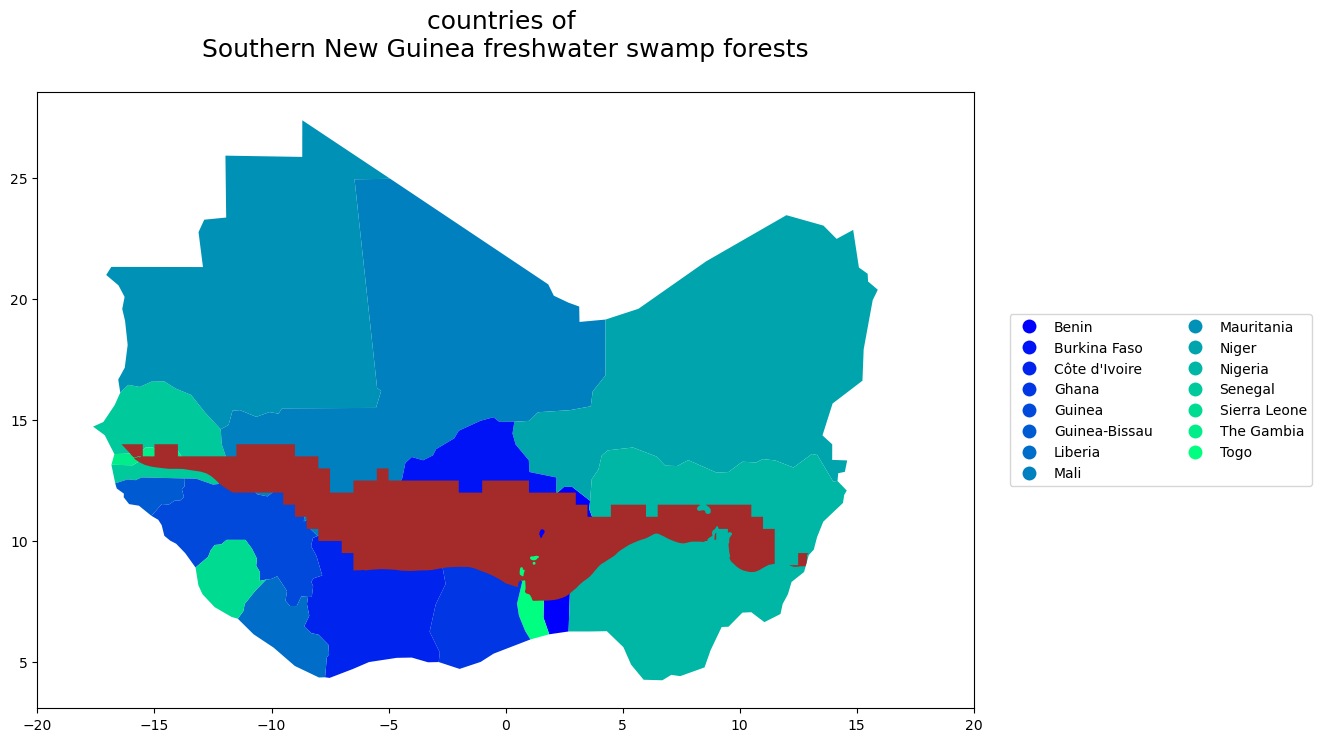

In [10]:
plot_within(subregion, 'country', 'countries of \nSouthern New Guinea freshwater swamp forests\n', 2)
plt.xlim(-20,20);

### AgroEcological zones

In [11]:
path = 'data/Bioclimatic and ecological zones/GlobalAgroEcologicalZones_GAEZ.geojson'
agros = {1: 'Steep terrain', 2: 'Artic/Cold', 3: 'Desert/Arid', 4: 'Irrigated Soils', 5: 'Hydromorphic soils', 
 6: 'Dry, good soils', 7: 'Dry, moderate soils', 8: 'Dry, poor soils', 9: 'Moist, good soils', 
 10: 'Moist, moderate soils', 11: 'Moist, poor soils', 12: 'Sub-humid, good soils', 13: 'Sub-humid, moderate soils', 
 14: 'Sub-humid, poor soils', 15: 'Humid, good soils', 16: 'Humid, moderate soils',
         17: 'Humid, poor soils', 18:'Water'}

agroeco_df = Read(path)
agroeco_df = agroeco_df.wrangle(replace_values = True, column_to_replace = 'value',
                                replacing_values =agros)
gaez = gpd.clip(agroeco_df, fav_forest)
gaez.head()

value  \
81765            Irrigated Soils   
81660  Sub-humid, moderate soils   
81665              Steep terrain   
81664      Sub-humid, good soils   
81663  Sub-humid, moderate soils   

                                                geometry  \
81765  POLYGON ((-70.90000 19.50000, -71.00000 19.500...   
81660  POLYGON ((11.40000 9.85000, 11.40000 9.75000, ...   
81665  POLYGON ((11.40000 9.75000, 11.40000 9.85000, ...   
81664  POLYGON ((9.55000 9.90000, 9.60000 9.90000, 9....   
81663  POLYGON ((11.15000 9.75000, 11.15000 9.65000, ...   

                         centroid  
81765  POINT (-70.94286 19.50000)  
81660  POINT (-71.83167 19.58500)  
81665  POINT (-70.69643 19.60357)  
81664  POINT (-70.87500 19.62500)  
81663  POINT (-71.02500 19.62500)

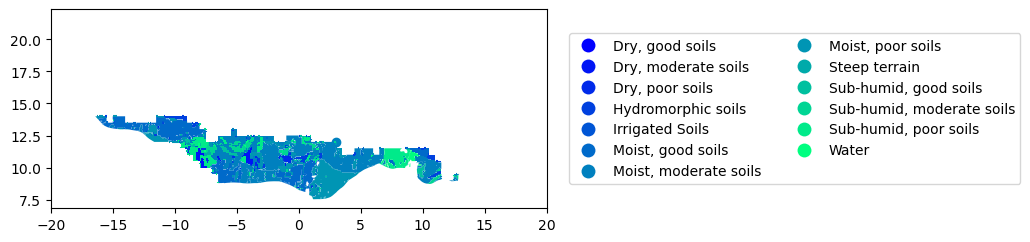

In [12]:
plot(gaez, 'value')

### climate

In [13]:
climates = {1: 'Warm Temperate Moist', 2: 'Warm Temperate Dry', 3: 'Cool Temperate Moist', 4: 'Cool Temperate Dry', 
5: 'Polar Moist', 6: 'Polar Dry', 7: 'Boreal Moist', 8: 'Boreal Dry', 9: 'Tropical Montane', 10: 'Tropical wet',
 11: 'Tropical Moist', 12: 'Tropical Dry'}

In [14]:
url = 'data/climate/IPCC_ClimateZoneMap_Vector.geojson'

climate = Read(url)
climate = climate.wrangle(replace_values = True, column_to_replace = 'class_name',
               replacing_values = climates)
clim = gpd.clip(climate, fav_forest)
clim = clim.drop((clim[clim['class_name'] == 0]).index)
clim.head()

class_name                                           geometry  \
20423    Tropical Moist  POLYGON ((10.85000 9.50000, 10.85000 9.40000, ...   
20408    Tropical Moist  POLYGON ((11.15000 9.60000, 11.15000 9.50000, ...   
20440  Tropical Montane  POLYGON ((8.65000 10.15000, 8.72503 10.15000, ...   
20250  Tropical Montane  POLYGON ((8.90000 10.50000, 8.94546 10.50000, ...   
22736      Tropical Dry  GEOMETRYCOLLECTION (POLYGON ((12.75000 9.25000...   

                        centroid  
20423   POINT (10.80000 9.45000)  
20408   POINT (11.12500 9.55000)  
20440    POINT (8.93947 9.58840)  
20250   POINT (8.95000 10.45000)  
22736  POINT (14.83832 19.08908)

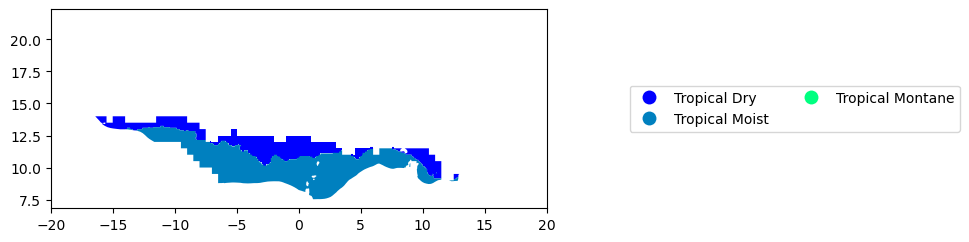

In [15]:
plot(clim, 'class_name')

In [16]:
clim = clim.drop((clim[clim['class_name'] == 0]).index)

###### Climate_shifts

In [17]:
def climate_shifts(year, scenario):
    replace = {
    11: 'Af', 12 :'Am', 13 : 'As', 14 : 'Aw', 21 : 'BWk', 22 : 'BWh', 26 : 'BSk', 27 : 'BSh',
    31 : 'Cfa', 32 : 'Cfb', 33 : 'Cfc', 34 : 'Csa', 35 : 'Csb', 36 : 'Csc', 37 : 'Cwa', 38 : 'Cwb', 
    39 : 'Cwc', 41 : 'Dfa', 42 : 'Dfb', 43 : 'Dfc', 44 : 'Dfd', 45 : 'Dsa', 46 : 'Dsb', 47 :'Dsc', 
    48 :'Dsd', 49 : 'Dwa', 50 : 'Dwb', 51 : 'Dwc', 52 : 'Dwd', 61 : 'EF', 62 :'ET',
    }
    if scenario:
        clim_shift = Read(f'data/climate/KoppenGeigerClimateShifts/{year}-{scenario}.geojson')
    else:   
        clim_shift = Read(f'data/climate/KoppenGeigerClimateShifts/{year}.geojson')
    clim_shift = clim_shift.wrangle(replace_values = True,
               column_to_replace= 'gridcode', replacing_values = replace)
    forest_clim_shift = gpd.clip(clim_shift, fav_forest)
    return forest_clim_shift

In [18]:
def plot_climate_shifts(years, scenario, title):
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15,10))
    for i in range(len(years)):
        if scenario:
            climate_shifts(years[i], scenario).plot(column = 'gridcode', ax = ax[i], cmap = 'winter',
                                                    legend = True)
        else:
            climate_shifts(years[i], None).plot(column = 'gridcode', ax = ax[i], cmap = 'winter',
                                                legend = True)
        ax[i].set_title(years[i], fontdict = {'fontsize': 10})
    for ax in ax.flat:
        ax.axis('off')
        ax.set_xlim(left=-20, right=20)
        ax.set_ylim(bottom=0, top=20)
    plt.suptitle(title, y =0.7,
                 size = 24)
    fig.tight_layout(pad = 0.2)

<b>1901 - 2000 (No scenarios)

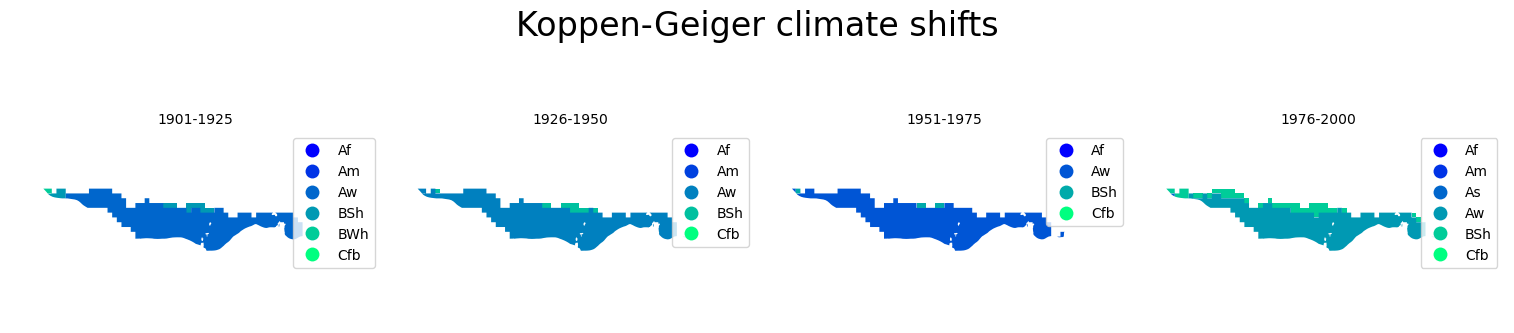

In [19]:
years = ['1901-1925', '1926-1950', '1951-1975', '1976-2000']
plot_climate_shifts(years, None, 'Koppen-Geiger climate shifts',)

<b>A1F1

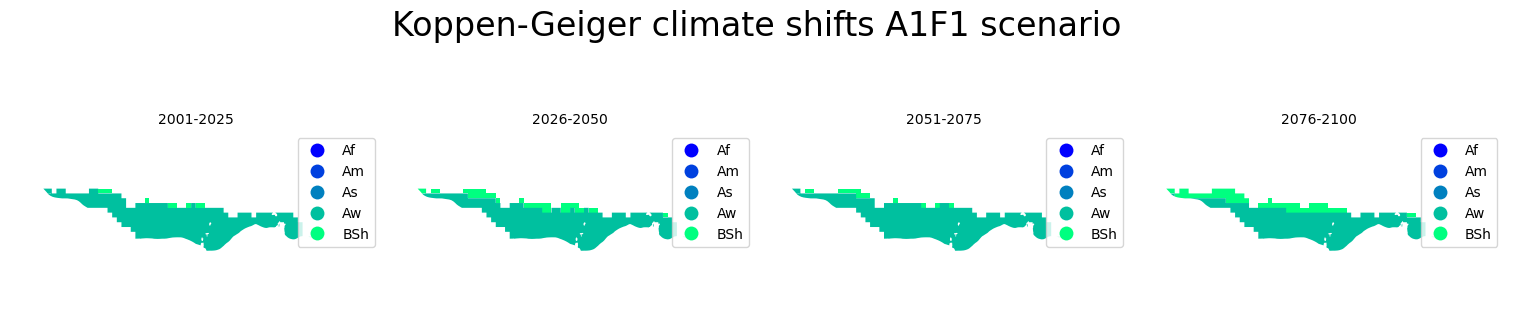

In [20]:
years = ['2001-2025', '2026-2050', '2051-2075', '2076-2100']
plot_climate_shifts(years, 'A1FI', 'Koppen-Geiger climate shifts A1F1 scenario')

<b>A2

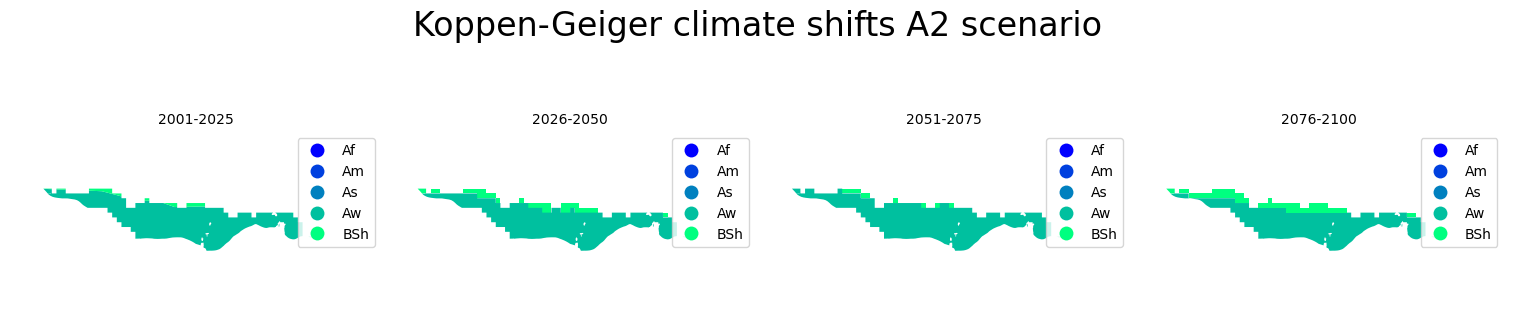

In [21]:
years = ['2001-2025', '2026-2050', '2051-2075', '2076-2100']
plot_climate_shifts(years, 'A2', 'Koppen-Geiger climate shifts A2 scenario')

<b>B1

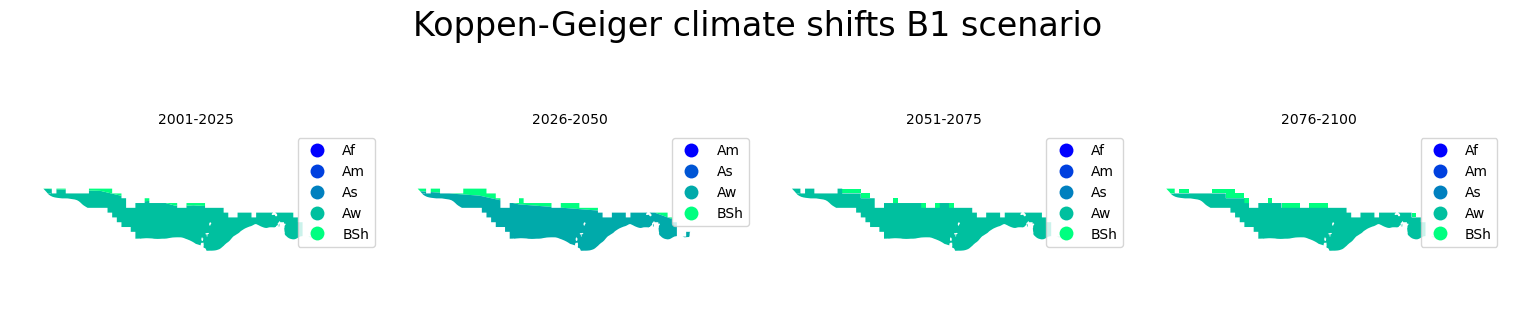

In [22]:
years = ['2001-2025', '2026-2050', '2051-2075', '2076-2100']
plot_climate_shifts(years, 'B1', 'Koppen-Geiger climate shifts B1 scenario')

<b>B2

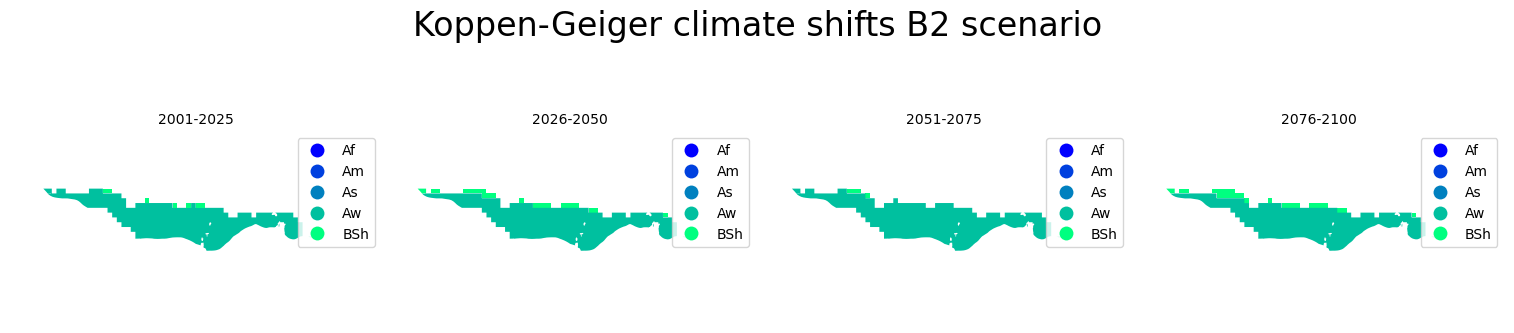

In [23]:
years = ['2001-2025', '2026-2050', '2051-2075', '2076-2100']
plot_climate_shifts(years, 'B2', 'Koppen-Geiger climate shifts B2 scenario')

In [24]:
def read_tiff(data, title):
    f, ax = plt.subplots(1, 2, figsize=(10, 4))
    for i in range(len(data)):
        path = f'data/Bioclimatic and ecological zones/{data[i]}.tif'
        tiff_data = rxr.open_rasterio(path, masked=True).squeeze()
        clipped1 = tiff_data.rio.clip(fav_forest.geometry.apply(mapping),
                                          # This is needed if your GDF is in a diff CRS than the raster data
                                          fav_forest.crs)
        fav_forest.plot(ax = ax[i], color = 'brown')
        clipped1.plot(ax=ax[i], cmap = 'winter')
        ax[i].set_title(data[i], fontdict = {'fontsize': 10})
    for ax in ax.flat:
        ax.axis('off')
        ax.set_xlim(left=-20, right=20)
        ax.set_ylim(bottom=0, top=20)
    plt.suptitle(title, y = 1.2,
                 size = 24)
    f.tight_layout(pad = 0.2)

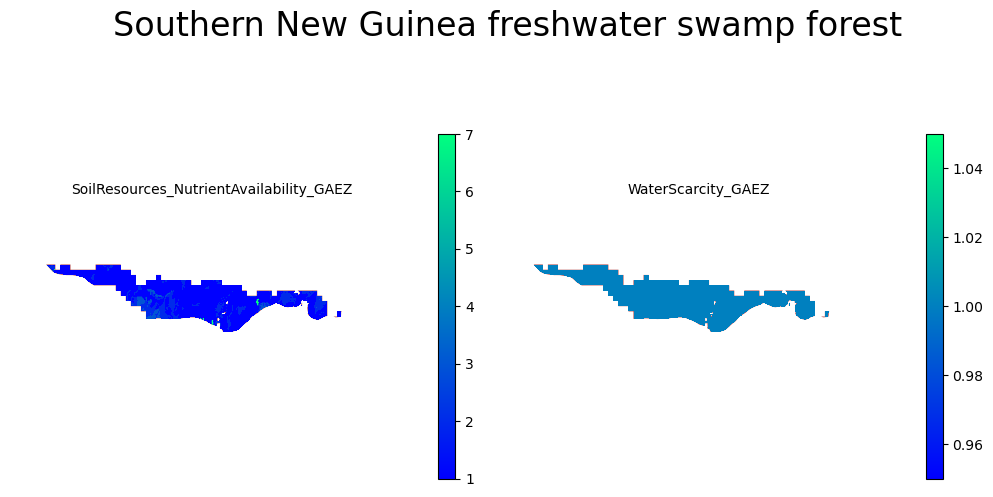

In [25]:
read_tiff(['SoilResources_NutrientAvailability_GAEZ',
          'WaterScarcity_GAEZ'], 'Southern New Guinea freshwater swamp forest')

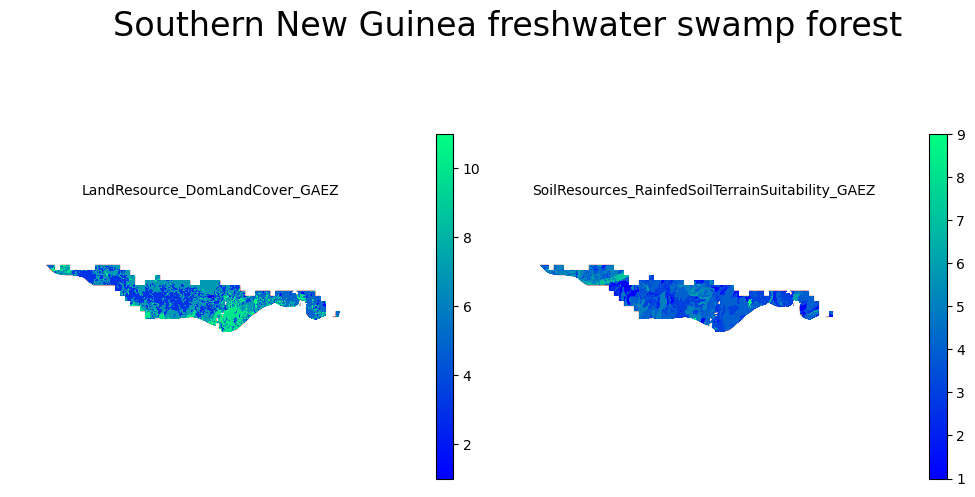

In [26]:
read_tiff(['LandResource_DomLandCover_GAEZ',
          'SoilResources_RainfedSoilTerrainSuitability_GAEZ'], 'Southern New Guinea freshwater swamp forest')

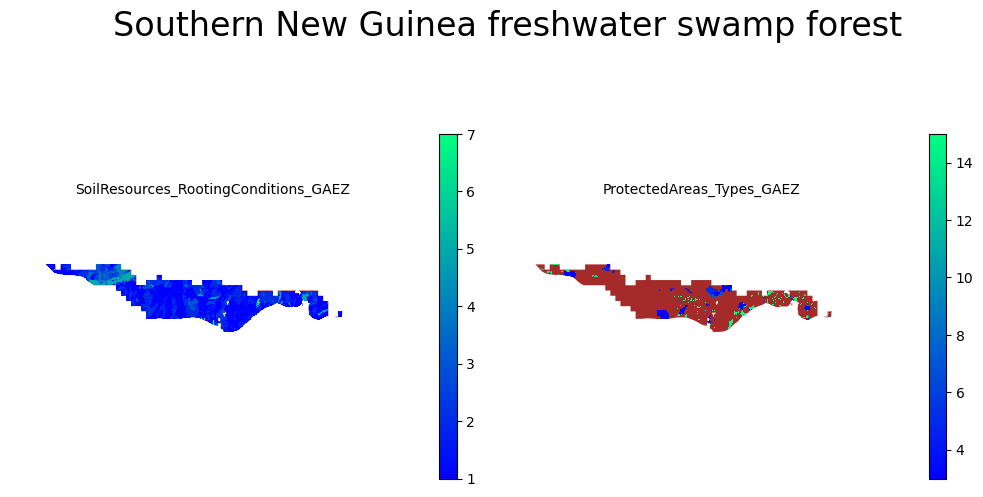

In [27]:
read_tiff(['SoilResources_RootingConditions_GAEZ',
          'ProtectedAreas_Types_GAEZ'], 'Southern New Guinea freshwater swamp forest')

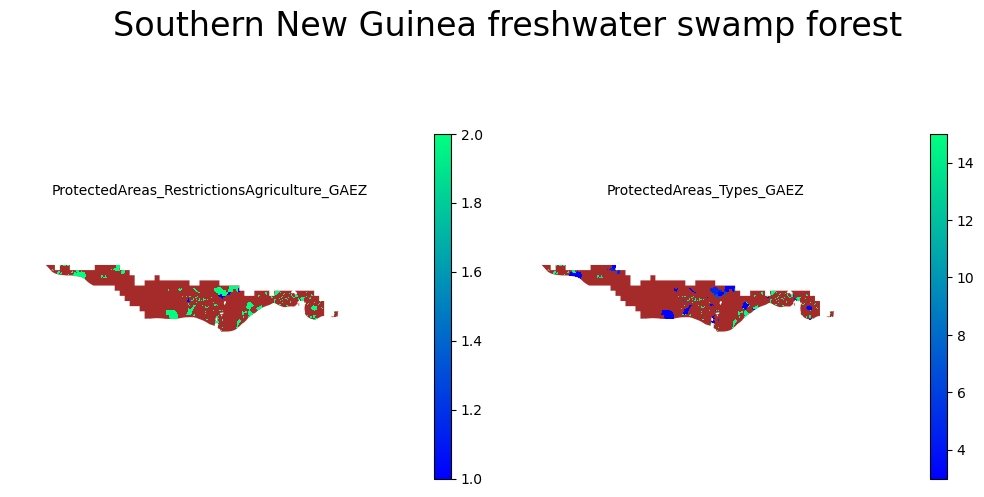

In [28]:
read_tiff(['ProtectedAreas_RestrictionsAgriculture_GAEZ',
          'ProtectedAreas_Types_GAEZ'], 'Southern New Guinea freshwater swamp forest')

 ##### Forests

<b>Managed forests concession

In [1]:
def plot_within(data, column = None):
    ax = fav_forest.plot(figsize= (20, 8))
    data.plot(ax = ax, cmap = 'winter', column = column, legend = True)
    plt.title('title', fontdict = {'fontsize' : 18});

In [30]:
url = 'https://datasets.mojaglobal.workers.dev/0:/LandCover/Forest/ManagedForestConcessions/ManagedForestConcessions_LBR.geojson'
forest_concession = Read(url)
forest_concession.retrieve_data()
forest_concession = forest_concession.wrangle(online = True)
forest_concession.head(2)

id  objectid country   name company group_comp group_coun legal_term  \
0  47        47     LBR  FMC a                                            
1  48        48     LBR  FMC b                                            

  status province source last_updat  shape_leng      area_geo  shape_length  \
0                                      1.998015  1.143232e+09      1.998015   
1                                      1.157871  5.563628e+08      1.157871   

   shape_area                                           geometry  \
0    0.093627  POLYGON ((-9.63809 7.58342, -9.67405 7.61019, ...   
1    0.045417  POLYGON ((-9.44694 5.81031, -9.51802 5.82799, ...   

                   centroid  
0  POINT (-9.71605 7.35382)  
1  POINT (-9.41711 5.68310)

(-20.0, 20.0)

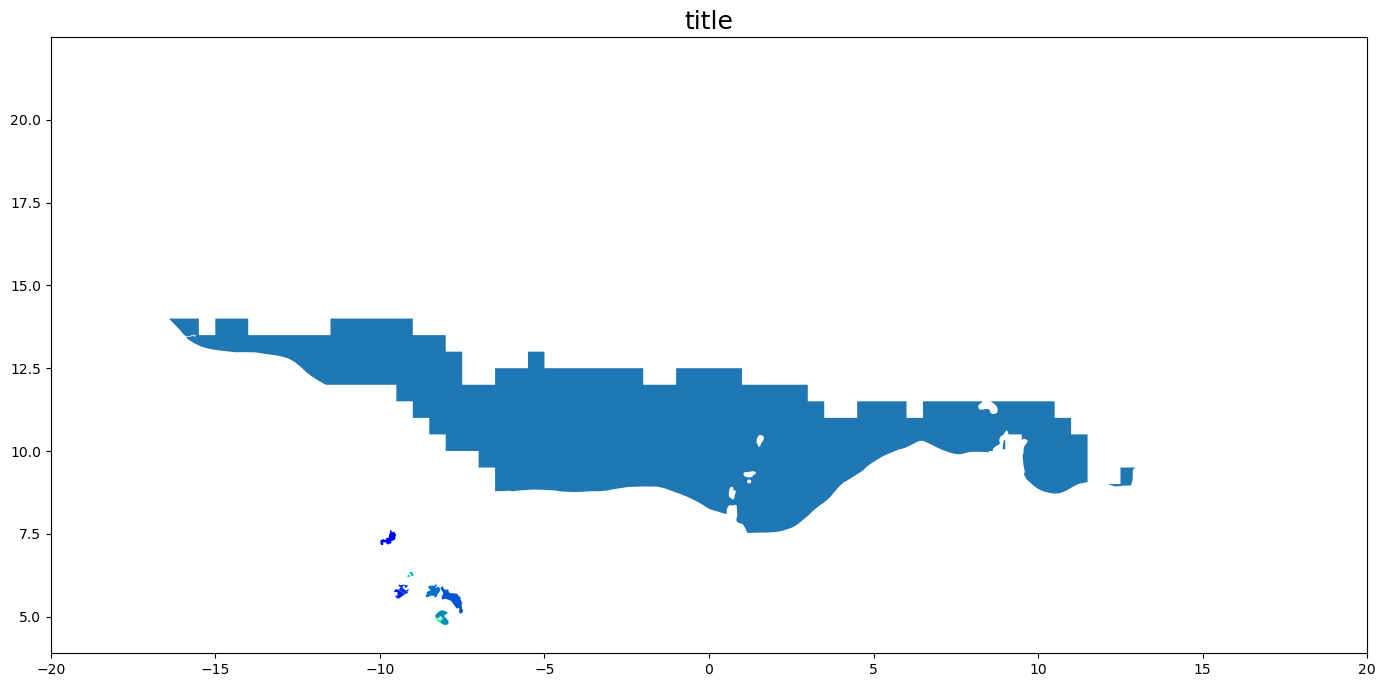

In [31]:
plot_within(forest_concession, )
plt.xlim(-20, 20)

data on managed forest concession for liberia want to check if the forest covers it

In [32]:
soil_resource = Read('https://datasets.mojaglobal.workers.dev/0:/Soil/World%20Soil%20Resources/World_Soil_Resources_wgs84.geojson')
soil_resource.retrieve_data()
soil_resource = soil_resource.wrangle(online = True)
soil_resource = gpd.clip(soil_resource, fav_forest)
soil_resource.head()
# soil_resources.append(soil_resource)
# soil = gpd.GeoDataFrame( pd.concat(soil_resources, ignore_index=True) )

sname         ipcc                                           geometry  \
32   WAT  Waterbodies  MULTIPOLYGON (((-97.65724 21.64268, -97.65744 ...   
19    LP     Leptosol  MULTIPOLYGON (((-86.78835 21.05158, -86.79645 ...   
29    SC    Solonchak  POLYGON ((-13.66273 13.46387, -13.83254 13.294...   
31    VR     Vertisol  MULTIPOLYGON (((-71.71528 19.72417, -71.72058 ...   
22    LX      Lixisol  MULTIPOLYGON (((-14.02358 13.80349, -14.11379 ...   

                     centroid  
32  POINT (-7.03050 40.05349)  
19  POINT (46.24798 32.16133)  
29   POINT (32.76967 7.95292)  
31   POINT (66.75923 0.32992)  
22   POINT (31.59579 0.76833)

(-20.0, 20.0)

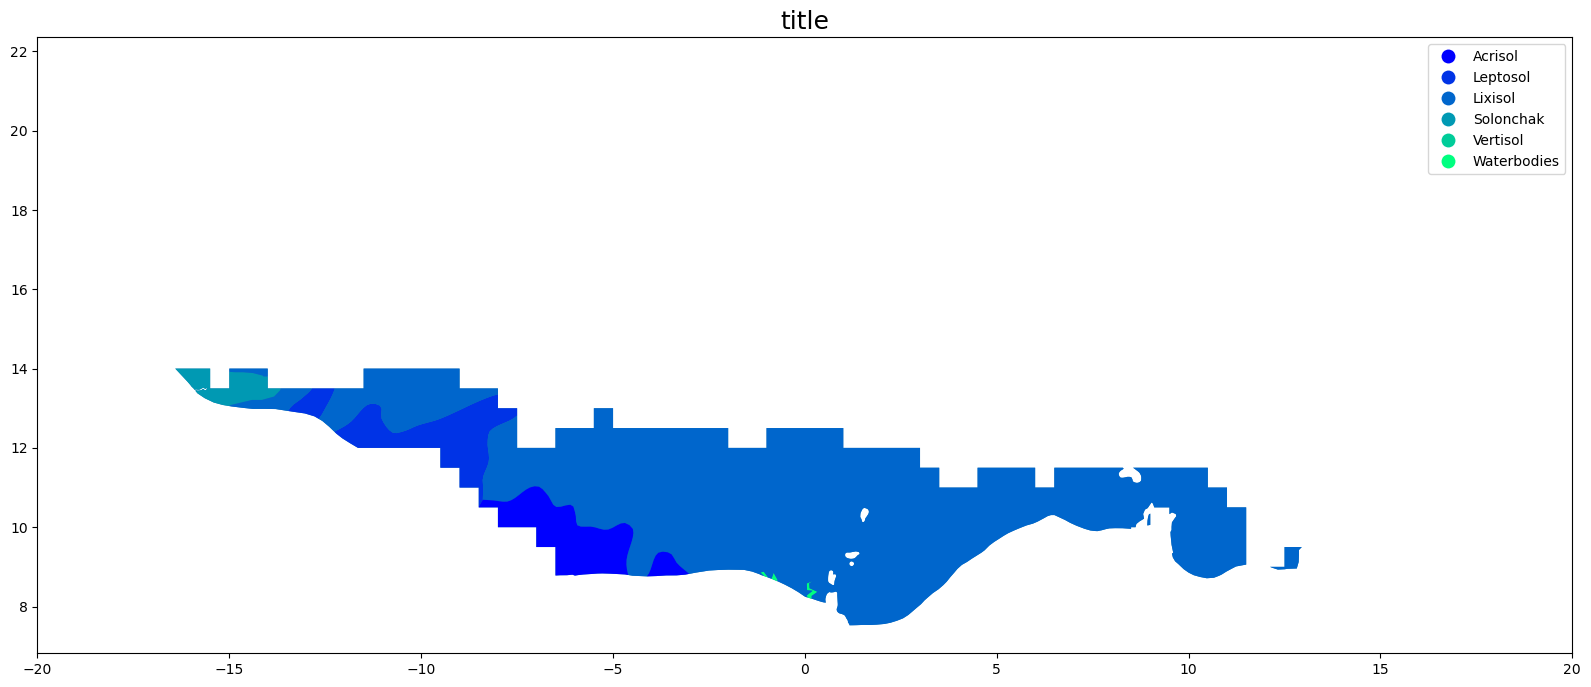

In [33]:
plot_within(soil_resource, 'ipcc')
plt.xlim(-20, 20)

Text(0.5, 1.0, 'a')

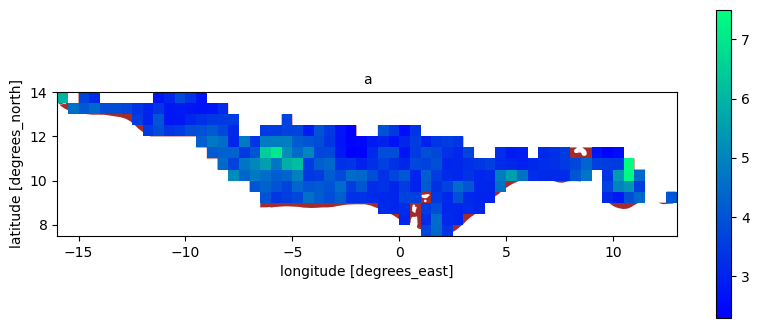

In [34]:
f, ax = plt.subplots(figsize=(10, 4))
path = f'data/soil/GlobalSoilOrganicCarbonDensityinkgCm_1mDepth.tif'
tiff_data = rxr.open_rasterio(path, masked=True).squeeze()
clipped1 = tiff_data.rio.clip(fav_forest.geometry.apply(mapping),
                                          # This is needed if your GDF is in a diff CRS than the raster data
                                          fav_forest.crs)
fav_forest.plot(ax = ax, color = 'brown')
clipped1.plot(ax=ax, cmap = 'winter')
ax.set_title('a', fontdict = {'fontsize': 10})